# Mount Whitney, California Land Cover Types

[Github Repository](https://github.com/mwidas/land-cover-statistics-ca)

### Background

In this notebook an exploration of land cover types around Mount Whitney, California is conducted. A bar graph showing percentages of land cover and a visual representation of where Mount Whitney is located within California will be the deliverables created.

### Highlights
 - Data wrangling and exploration with `pandas`
 - Geospatial data wrangling with `geopandas` and `rioxarray`
 - Merging of tabular and vector data
 - Creating and customizing a map
 - Creating and customizing a horizontal bar plot with `matplotlib`


### Data

**First dataset**

A small section of the GAP/LANDFIRE National Terrestrial Ecosystems data for 2011, from the US Geological Survey (USGS). This is a raster file with a 30 m x 30 m pixel resolution. Each cell in the raster has a number representing the type of land cover.

The data was pre-processed in the Microsoft Planetary Computer to show a small region around Mount Whitney, California.

Further information about the dataset can be accessed via the the dataset’s Digital Object Identifier [(DOI)](https://doi.org/10.5066/F7ZS2TM0) link.

**Second dataset**

A shapefile of CA Geographic Boundaries. 
This is a subset of the US Census Bureau's 2016 TIGER database, which only has the state boundary. The URL for this data can be accessed [here](https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b).


**Third dataset**

A csv file with the name of the land cover associated with each code.

### Final Visualizations 

The final visualizations produced in this exploration will be a map for geographic context to indicate where our data around Mount Whitney is located from, and a figure highlighting the dominant land cover/land use types around Mount Whitney.

![map](images/ca_mt_whitney_map.png)

![bar plot showing dominant land class types](images/percent_land_cover_plot.png)

### Let's Get Coding



### Load necessary packages

In [13]:
# import libraries and functions needed
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines # for creating legend shapes

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box



### Import Land Cover data

I downloaded the `.tif ` file containing land cover information for the area around Mount Whitney, CA and saved this as lulc short for land use/land cover. `rioxarray` and `os` allow for the land cover data to be opened as a raster and allows for the exploration of the file, like exploring the projection it is in.


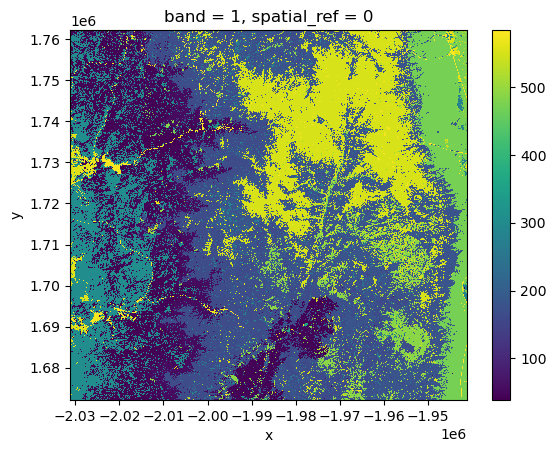

In [14]:
# load in .tif file
lulc_fp = os.path.join(os.getcwd(),'data','land_cover.tif')

# store .tif file as lulc
lulc = rioxr.open_rasterio(lulc_fp)

# plot the lulc raster
lulc.plot()

### Import outline of California

I used a URL that links to the California shapefile in order to access the shape of California.

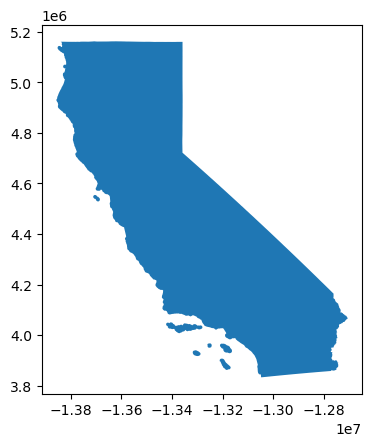

In [15]:
# load ca shapefile
ca = gpd.read_file("https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/download/ca-state-boundary.zip")

# look at ca
ca.plot()

# update ca to the same crs as lulc
ca = ca.to_crs('epsg:5070')

### Creating a Bounding Box and Point for Mt. Whitney

To create the map showing where the lulc tile is within the state of California and how that related to Mount Whitney we will be creating a bounding box based off of `lulc` and a point created from coordinates from Mount Whitney.

In [16]:
# create a GeoDataFrame with the lulc bounding box
bbox = gpd.GeoDataFrame({"id":1,"geometry":[box(*lulc.rio.bounds())]})

# create geodataframe with mount whitney point
mt_whitney = gpd.GeoDataFrame(geometry=[Point(-118.2923, 36.5785)],
                           crs='epsg:4326')


# update mt_whitneys crs to the same crs as lulc
mt_whitney = mt_whitney.to_crs('epsg:5070')

### Creating a Map to Provide Geographic Context

Now that we have finished loading and updating our data we can explore the spatial relationship of our data. We will use `matplotlib` to create a map that highlights the location of Mount Whitney in relation to the area of land use/land cover data we have within the state of California. 


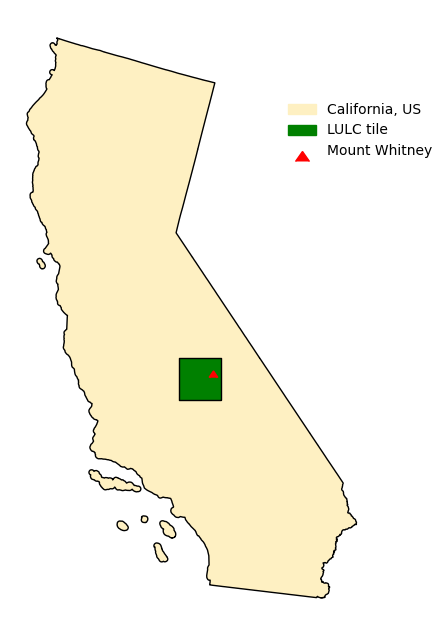

In [17]:
# create figure
fig, ax = plt.subplots(figsize=(12,8))

ax.axis('off')

ca.plot(ax=ax,  # add california outline
       color='#fef0c2',
       edgecolor='black')
ca_patch = mpatches.Patch(color='#fef0c2',
                          label='California, US')

bbox.plot(ax=ax,   # add lulc bounding box
         color ='green',
         edgecolor ='black',
         label ='LULC tile')
bbox_patch = mpatches.Patch(color='green',
                            label='LULC tile')

mt_whitney.plot(ax=ax,     # add marker for Mount Whitney
               color = 'red',
               marker = 6)

mt_whitney_triangle = mlines.Line2D([], [], color='red',
                                    marker=6,
                                    markersize=10,
                                    label='Mount Whitney',
                                   lw=0)

ax.legend(handles = [ca_patch, bbox_patch, mt_whitney_triangle], frameon=False, loc=(0.75, 0.75))

# --------------------------------------
# save figure
plt.savefig('images/ca_mt_whitney_map.png', bbox_inches='tight',  dpi=100)

plt.show()

### Import Land Cover Type Data 

I downloaded data that contained land cover type and accompanying codes in order to explore the land cover types present in the `lulc` raster.

In [18]:
# import the tabular data 
class_names = pd.read_csv('data/GAP_National_Terrestrial_Ecosystems.csv')

class_names.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


### Lulc Raster Exploration

In order to more effectively use our lulc raster the `squeeze()` and `drop()` functions will be applied.

### Raster Reduction

In [19]:
# remove length 1 dimension (band)
lulc = lulc.squeeze()

# remove coordinates associated to band
lulc = lulc.drop('band')


### Calculation of Area Covered by Land Cover Class

Create a data frame that will store the percentages covered by each land cover class.

In [20]:
# get the number of pixels per class in lulc
pixels = np.unique(lulc, return_counts=True)

# initialize dictionary with pixels arrays data 
pix = {'code' : pixels[0],
     'number_pixels' : pixels[1],
     }

# create data frame
pix_counts = pd.DataFrame(pix)

# add class names
classes = pd.merge(pix_counts,
                   class_names,
                   how = 'left',
                   on = 'code')

# calculate the total_pixels from attributes of lulc
total_pixels = classes['number_pixels'].sum()

# add the percentage of area covered by each class and round to 8 decimal points
classes['percentage_covered'] = round((classes['number_pixels']/total_pixels*100), 8)


### Visualization of Land Cover Types

Now that we have calculated how much of our raster is covered by each land cover, let's create a bar plot to help us visualize the dominant types. Using `matplotlib` a horizontal bar plot is made that  highlights the classes with more than 1% land cover in decreasing order.

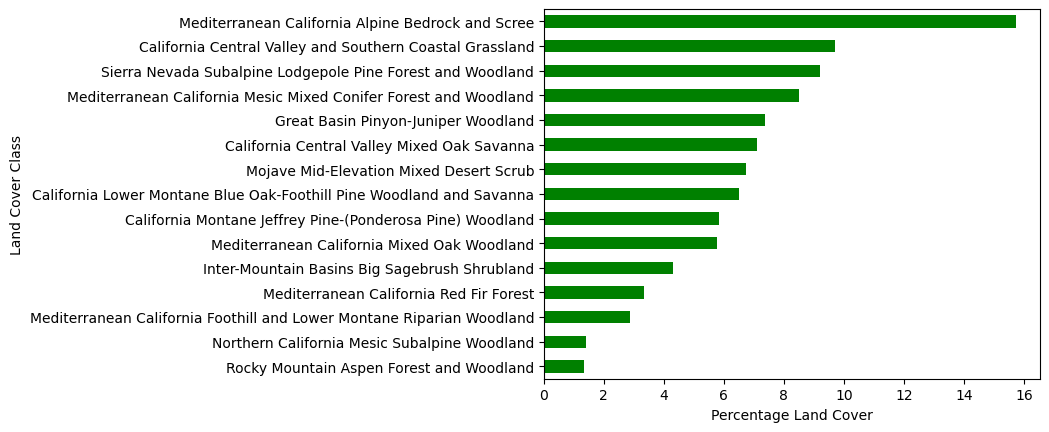

In [22]:
# create horixontal bar plot showing the classes with more than 1% land cover in decreasing order
classes.loc[(classes['percentage_covered']>1)].sort_values(by='percentage_covered', ascending=True).plot.barh(x='class_label',
                                                        y='percentage_covered',
                                                                                                              xlabel = "Percentage Land Cover",
                                                                                                              ylabel = "Land Cover Class",
                                                                                                              color = "green",
                                                                                                              legend = False)
                                                                                                              

# -----------------------------
# save figure
plt.savefig('images/percent_land_cover_plot.png', bbox_inches='tight',  dpi=100)

plt.show()